# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from boostaroota import BoostARoota

# <center id="part0"> Описание задачи


**Предыстория:** мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.

**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.

**Как компания решает задачу:**

- Собирает данные о поездках и состоянии машин до поломок.

- Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.


## <center> Знакомство с данными


### Информация про машины с таргетом (основной датасет)


In [170]:
car_train = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
277,H10820003r,Kia Rio X,economy,petrol,4.04,2014,63167,2019,49.45,engine_ignition
729,B-2081255O,Smart Coupe,economy,petrol,3.96,2017,138101,2017,44.60,gear_stick
1792,W98320909n,Nissan Qashqai,standart,petrol,3.52,2015,78008,2019,61.71,another_bug
593,m-1806910Q,Smart ForFour,economy,petrol,5.06,2017,118244,2020,26.73,wheel_shake
1116,W-2145474K,Renault Kaptur,standart,petrol,5.56,2012,25972,2016,27.32,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)


### Информация про поездки


In [171]:
rides_info = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
222054,u15432191N,P20515953Y,G1N,2020-01-17,7.78,36,392,50,79.000000,0,1802.516217,0,-13.457897,4.522
42603,k54202601b,C20191765o,F1U,2020-03-18,4.58,54,480,50,91.217654,0,2728.793598,0,0.413078,8.271
640560,N29271003f,t-5863497D,A1R,2020-02-05,4.40,26,411,50,70.000000,0,1346.056137,0,4.335701,-28.470
10189,b10925946Q,A15262612g,h1R,2020-02-21,3.36,19,166,54,90.000000,1,638.516516,0,4.379964,-11.642
607092,h11075423A,r-1304067j,z1w,2020-01-04,5.13,36,319,43,75.000000,1,683.580443,0,-3.716576,2.100


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` — длительность (время), пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)


### Информация про водителей


In [172]:
driver_info = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
7385,46,8.7,1861,11.0,O17361596y,0,2021-9-13
14922,39,8.0,822,12.0,W35029169a,1,2020-9-16
13477,24,9.2,540,13.0,G14930965M,1,2020-7-4
12621,19,7.9,73,24.0,E16259413X,1,2020-1-22
13736,42,7.2,514,NaN,F15129943U,0,2019-6-30


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)
- `first_ride_date` — дата первой поездки


### Информация про ремонт машин


In [173]:
fix_info = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
38808,i-2453146k,AZ,2020-5-12 17:6,reparking,1.0,27
122298,Y-6116422G,ED,2019-7-10 7:58,reparking,1.0,26
62589,A-1339912r,HT,2021-4-17 7:54,repair,5.0,42
68319,n59321309Q,GY,2020-12-29 0:44,repair,7.0,38
111498,k-1039028Y,XH,2019-4-12 10:45,repair,5.5,14


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)


# Домашнее задание 1. Генерация и фильтрация признаков


<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>


<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.


## 1. Генерация признаков из дополнительных датасетов (6 баллов)


<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:

- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)

<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>


<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).


### Пример расчета признака


In [174]:
# Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

In [175]:
rides_info['rating_min'] = rides_info.groupby(
    'car_id')['rating'].transform('min')
rides_info['rating_mean'] = rides_info.groupby(
    'car_id')['rating'].transform('mean')
rides_info['distance_sum'] = rides_info.groupby(
    'car_id')['distance'].transform('sum')
rides_info['speed_max_max'] = rides_info.groupby(
    'car_id')['speed_max'].transform('max')
rides_info['rides_count'] = rides_info.groupby(
    'car_id')['ride_id'].transform('count')
rides_info['ride_duration_sum'] = rides_info.groupby(
    'car_id')['ride_duration'].transform('sum')
rides_info['user_ride_quality_mean'] = rides_info.groupby(
    'car_id')['user_ride_quality'].transform('mean')
rides_info['deviation_normal_median'] = rides_info.groupby(
    'car_id')['deviation_normal'].transform('median')

df_rides_info = rides_info[[
    'car_id',
    'rating_min',
    'rating_mean',
    'distance_sum',
    'speed_max_max',
    'rides_count',
    'ride_duration_sum',
    'user_ride_quality_mean',
    'deviation_normal_median']].drop_duplicates()

df = pd.merge(left=car_train, right=df_rides_info, on='car_id', how='left')

In [176]:
fix_info['destroy_degree_mean'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('mean')
fix_info['work_duration_sum'] = fix_info.groupby(
    'car_id')['work_duration'].transform('sum')
fix_info['destroy_degree_std'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('std')

df_fix_info = fix_info[[
    'car_id',
    'destroy_degree_mean',
    'work_duration_sum',
    'destroy_degree_std']].drop_duplicates()

In [177]:
df_driver_info = driver_info[['user_id', 'age',
                              'user_time_accident', 'user_rating']]

df_driver_rides = pd.merge(
    left=rides_info, right=df_driver_info, on='user_id', how='left')

df_driver_rides['age_mean'] = df_driver_rides.groupby('car_id')[
    'age'].transform('mean')
df_driver_rides['user_time_accident_max'] = df_driver_rides.groupby(
    'car_id')['user_time_accident'].transform('max')
df_driver_rides['user_rating_median'] = df_driver_rides.groupby(
    'car_id')['user_rating'].transform('median')

df_driver_rides_info = df_driver_rides[[
    'car_id',
    'age_mean',
    'user_time_accident_max',
    'user_rating_median'
]].drop_duplicates()

In [178]:
df = pd.merge(left=df, right=df_driver_rides_info, on='car_id', how='left')
df = pd.merge(left=df, right=df_fix_info, on='car_id', how='left')
df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,rides_count,ride_duration_sum,user_ride_quality_mean,deviation_normal_median,age_mean,user_time_accident_max,user_rating_median,destroy_degree_mean,work_duration_sum,destroy_degree_std
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,284624,-0.901190,0.0000,33.511494,77.0,8.2,3.048571,933,2.732847
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,174,386833,14.018105,4.8950,34.988506,23.0,8.0,2.917143,873,2.707233
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,174,356501,0.722771,-0.3490,32.839080,25.0,7.8,3.740000,915,2.978077
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,174,338171,-4.290370,11.3530,34.977011,86.0,8.4,4.085714,1007,3.237750
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,174,278016,-13.465342,13.6875,34.298851,72.0,8.1,3.880000,981,3.216758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,174,403228,-5.722741,2.4670,32.632184,83.0,8.1,3.900000,814,2.785895
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,174,231716,-8.048019,-15.7375,34.977011,70.0,8.1,1.935294,873,1.631115
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,174,291440,-0.251597,-10.2590,33.287356,23.0,7.8,2.782353,797,2.311168
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,174,414856,0.424606,-0.1275,31.977011,77.0,8.1,3.441176,857,2.899751


In [179]:
stop

NameError: name 'stop' is not defined

### Идеи для новых признаков


- `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
- `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
- `feature_mean` — среднее значение `deviation_normal` для каждой машины
- `feature_shift` — точка перегиба/сдвига для `deviation_normal`
- `feature_start` — значение точки старта для `deviation_normal`
- `feature_nans` — сумма пропусков для столбца `...` для каждой машины
- `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?


## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>


1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.

<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>


### Советы по Feature Selection


<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>

- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).

<b>Какие методы использовать:</b>

- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).


---

## Phik


In [ ]:
df_slctd = df.drop(['car_id'], axis=1)
df_slctd

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,rating_min,...,rides_count,ride_duration_sum,user_ride_quality_mean,deviation_normal_median,age_mean,user_time_accident_max,user_rating_median,destroy_degree_mean,work_duration_sum,destroy_degree_std
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,...,174,284624,-0.901190,0.0000,33.511494,77.0,8.2,3.048571,933,2.732847
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,...,174,386833,14.018105,4.8950,34.988506,23.0,8.0,2.917143,873,2.707233
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,...,174,356501,0.722771,-0.3490,32.839080,25.0,7.8,3.740000,915,2.978077
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,...,174,338171,-4.290370,11.3530,34.977011,86.0,8.4,4.085714,1007,3.237750
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,...,174,278016,-13.465342,13.6875,34.298851,72.0,8.1,3.880000,981,3.216758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,...,174,403228,-5.722741,2.4670,32.632184,83.0,8.1,3.900000,814,2.785895
2333,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,...,174,231716,-8.048019,-15.7375,34.977011,70.0,8.1,1.935294,873,1.631115
2334,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,...,174,291440,-0.251597,-10.2590,33.287356,23.0,7.8,2.782353,797,2.311168
2335,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,...,174,414856,0.424606,-0.1275,31.977011,77.0,8.1,3.441176,857,2.899751


interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'rides_count', 'ride_duration_sum', 'user_ride_quality_mean', 'deviation_normal_median', 'age_mean', 'user_time_accident_max', 'user_rating_median', 'destroy_degree_mean', 'work_duration_sum', 'destroy_degree_std']


c:\Users\nazar\YandexDisk\MIPT.Data Science\Competitive DS\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable rides_count for analysis 1. Dropping this column
  warnings.warn(


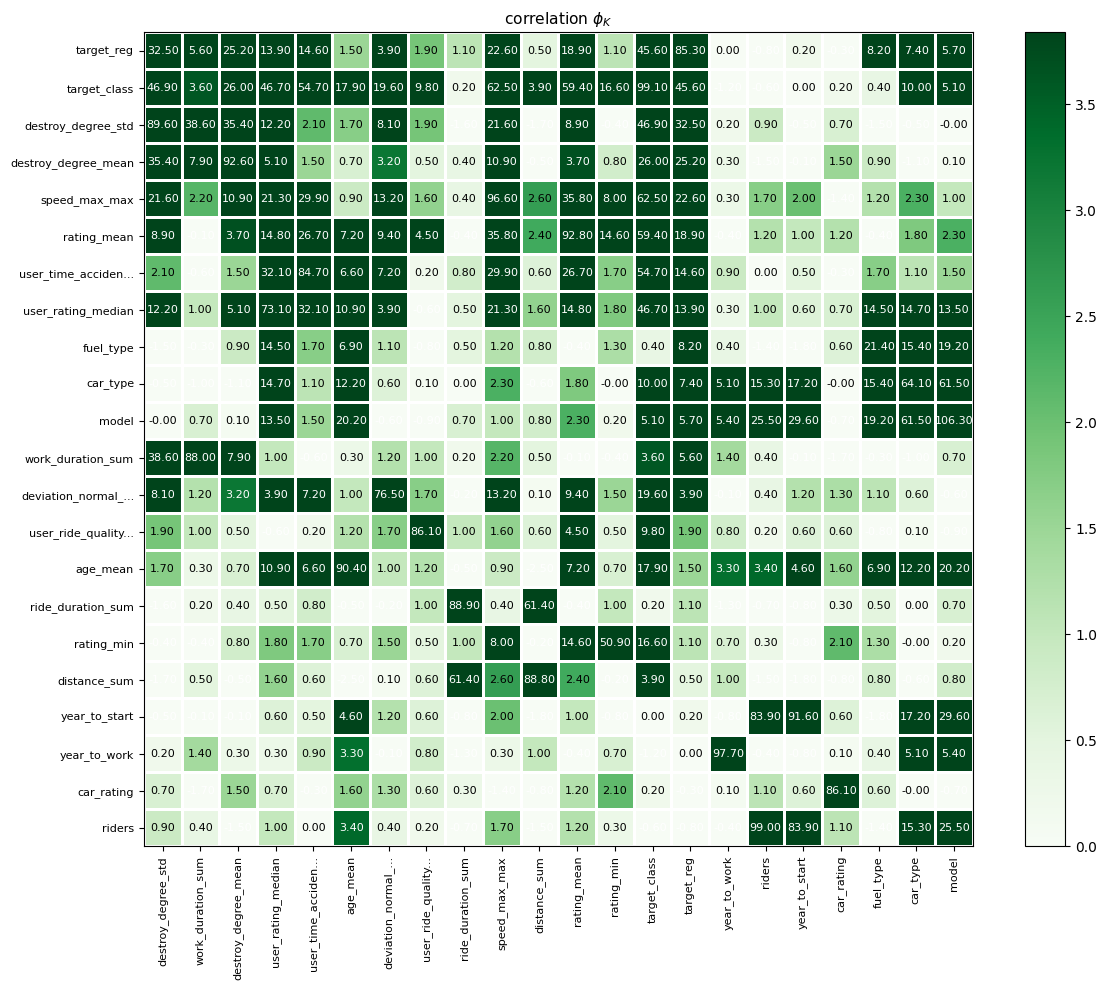

In [ ]:
significance_overview = df_slctd.significance_matrix().fillna(
    0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=3.84, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(12, 10))
plt.tight_layout()

In [ ]:
target_reg_ser = significance_overview['target_reg']
phik_filtered = target_reg_ser[target_reg_ser >
                               3.84].sort_values(ascending=False)[2:]
phik_filtered = pd.DataFrame(phik_filtered)
phik_filtered

,target_reg
destroy_degree_std,32.5
destroy_degree_mean,25.2
speed_max_max,22.6
rating_mean,18.9
user_time_accident_max,14.6
user_rating_median,13.9
fuel_type,8.2
car_type,7.4
model,5.7
work_duration_sum,5.6


---

## Catboost


Feature importance


In [ ]:
drop_cols = ['target_class', 'target_reg']
cat_cols = ['model', 'car_type',
            'fuel_type']
X = df_slctd.drop(drop_cols, axis=1)
y = df_slctd['target_reg']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(random_state=1, cat_features=cat_cols)
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False, verbose=0)

catboost_filtered = model.get_feature_importance(prettified=True)
catboost_filtered

,Feature Id,Importances
0,speed_max_max,25.432537
1,rating_mean,25.166819
2,destroy_degree_std,14.825589
3,user_time_accident_max,8.457977
4,destroy_degree_mean,8.338554
5,rating_min,3.965739
6,car_type,2.198680
7,fuel_type,1.454535
8,age_mean,1.327357
9,work_duration_sum,1.178459


Feature Selection


In [ ]:
summary = model.select_features(X_train, y_train,
                                eval_set=(X_test, y_test),
                                features_for_select='0-20',
                                num_features_to_select=10,
                                steps=1,
                                train_final_model=False,
                                logging_level='Silent')

In [ ]:
summary['selected_features_names']

['car_type',
 'fuel_type',
 'rating_min',
 'rating_mean',
 'distance_sum',
 'speed_max_max',
 'user_time_accident_max',
 'user_rating_median',
 'destroy_degree_mean',
 'destroy_degree_std']

---

## RFE


In [ ]:
X_train_ohe = pd.get_dummies(X_train[cat_cols], drop_first=True, dtype=int)
X_train = pd.concat((X_train.drop(columns=cat_cols), X_train_ohe), axis=1)

In [ ]:
estimator = CatBoostRegressor(random_state=42, verbose=0)

rfe = RFE(estimator=estimator, n_features_to_select=10)
rfe.fit(X_train, y_train)

RFE(estimator=<catboost.core.CatBoostRegressor object at 0x000001BFD82A3A40>,
    n_features_to_select=10)

In [ ]:
clf = rfe.estimator_
importance = clf.get_feature_importance()
col_names = rfe.get_feature_names_out()
importance_concat = np.concatenate(
    (col_names.reshape(-1, 1), importance.reshape(-1, 1)), axis=1)

rfe_filtered = pd.DataFrame(importance_concat, columns=[
                            'Feature', 'Importances']).sort_values(by='Importances', ascending=False)
rfe_filtered

,Feature,Importances
4,speed_max_max,24.180377
2,rating_mean,19.232554
9,destroy_degree_std,14.941153
6,user_time_accident_max,14.713682
7,destroy_degree_mean,8.709437
5,age_mean,4.089635
8,work_duration_sum,3.92471
1,riders,3.621119
3,distance_sum,3.47379
0,car_rating,3.113543


---

## Shap


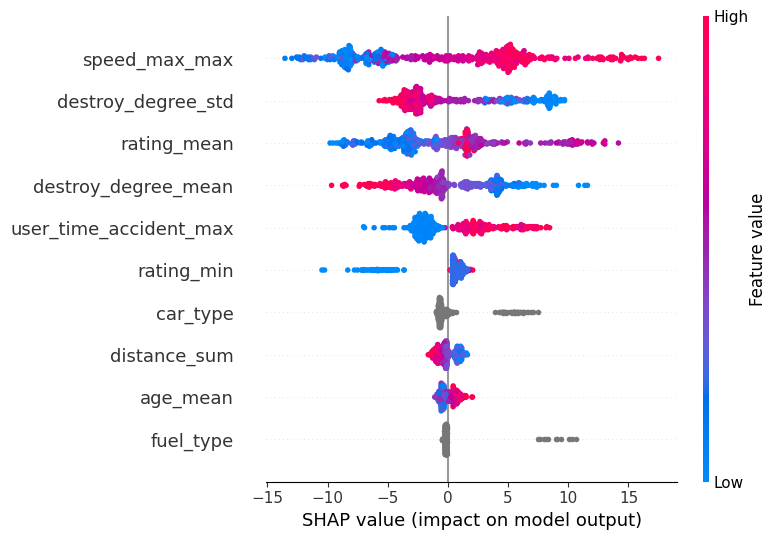

In [ ]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=10)

In [ ]:
col_names = np.array(X_test.columns)
val_abs = np.abs(shap_values)
val_abs_sum = val_abs.sum(axis=0)

data = np.concatenate(
    (col_names.reshape(-1, 1), val_abs_sum.reshape(-1, 1)), axis=1)
shap_filtered = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(
    by='Importance', ascending=False).iloc[:10, :]
shap_filtered

,Feature,Importance
10,speed_max_max,2901.131688
20,destroy_degree_std,1813.760579
8,rating_mean,1760.726841
18,destroy_degree_mean,1502.596877
16,user_time_accident_max,1225.620836
7,rating_min,638.577637
1,car_type,472.597505
9,distance_sum,290.698715
15,age_mean,246.344391
2,fuel_type,189.787056


In [ ]:
catboost_filtered_top = catboost_filtered.iloc[:10, :]

In [ ]:
phik_filtered_top = phik_filtered.iloc[:10, :]
phik_filtered_top = phik_filtered_top.reset_index()
catboost_filtered_top = catboost_filtered.iloc[:10, :].reset_index()
rfe_filtered_top = rfe_filtered.reset_index()
shap_filtered_top = shap_filtered.reset_index()
df_result = pd.concat((
    phik_filtered_top['index'],
    shap_filtered_top['Feature'],
    catboost_filtered_top['Feature Id'],
    rfe_filtered_top['Feature']
), axis=1)

df_result.columns = ['Phik', 'Shap', 'Catboost', 'RFE']
df_result

,Phik,Shap,Catboost,RFE
0,destroy_degree_std,speed_max_max,speed_max_max,speed_max_max
1,destroy_degree_mean,destroy_degree_std,rating_mean,rating_mean
2,speed_max_max,rating_mean,destroy_degree_std,destroy_degree_std
3,rating_mean,destroy_degree_mean,user_time_accident_max,user_time_accident_max
4,user_time_accident_max,user_time_accident_max,destroy_degree_mean,destroy_degree_mean
5,user_rating_median,rating_min,rating_min,age_mean
6,fuel_type,car_type,car_type,work_duration_sum
7,car_type,distance_sum,fuel_type,riders
8,model,age_mean,age_mean,distance_sum
9,work_duration_sum,fuel_type,work_duration_sum,car_rating


In [ ]:
sets = [set(df_result[col]) for col in df_result.columns]

intersected_cols = set.intersection(*sets)
print('Наиболее значимые признаки для всех методов (top=10):\n', *intersected_cols)

Наиболее значимые признаки для всех методов (top=10):
 user_time_accident_max rating_mean destroy_degree_std speed_max_max destroy_degree_mean


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели


<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.


## 1. Обучение первой модели (5 баллов)


1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на _обучающую_ и _валидационную_ выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.

<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = ['car_id', 'target_reg',
                 'target_class']  # то, что надо выбросить
targets = ['target_class']  # таргеты
cat_features = ['model', 'car_type', 'fuel_type']  # категориальные признаки

num_features = ['car_rating',
                'year_to_start',
                'riders',
                'year_to_work',
                'rating_min',
                'rating_mean',
                'distance_sum',
                'speed_max_max',
                'rides_count',
                'ride_duration_sum',
                'user_ride_quality_mean',
                'deviation_normal_median',
                'age_mean',
                'user_time_accident_max',
                'user_rating_median',
                'destroy_degree_mean',
                'work_duration_sum',
                'destroy_degree_std',
                ]  # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 18 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'rides_count', 'ride_duration_sum', 'user_ride_quality_mean', 'deviation_normal_median', 'age_mean', 'user_time_accident_max', 'user_rating_median', 'destroy_degree_mean', 'work_duration_sum', 'destroy_degree_std']
Целевые переменные ['target_class']


In [ ]:
X = df.drop(features2drop, axis=1)[cat_features+num_features]
Y = df[targets]

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=df[['car_type', 'fuel_type', 'target_class']])
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


model = CatBoostClassifier(
    depth=4,
    learning_rate=0.001,
    loss_function="MultiClass",
    eval_metric='Accuracy',
    cat_features=cat_features,
    task_type="GPU",
    thread_count=4,
    auto_class_weights="SqrtBalanced",
    early_stopping_rounds=100,
    verbose=0,
    random_state=1)

model.fit(train_pool, eval_set=val_pool, plot=True)
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy: {acc:.3f}')

(1869, 21) (468, 21) (1869, 1) (468, 1)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.968


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)


<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.


1. Визуализируйте важность признаков встроенным методом в `CatBoost` (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.

<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>


---

## Catboost


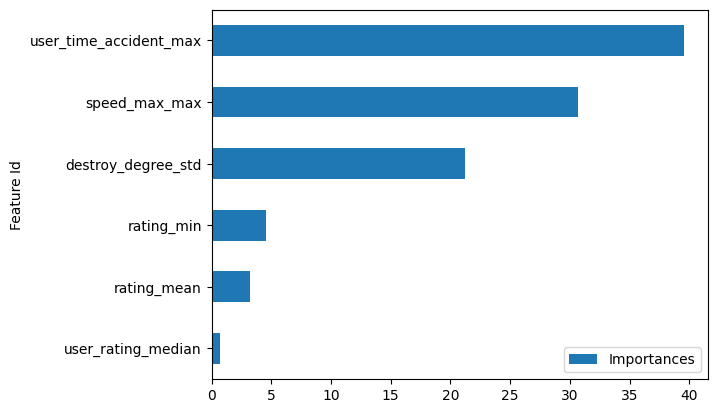

In [ ]:
catboost_fi = model.get_feature_importance(
    prettified=True).sort_values(by='Importances')
catboost_fi = catboost_fi[catboost_fi['Importances'] != 0]
catboost_fi.plot.barh(y='Importances', x='Feature Id')

---

## Shap


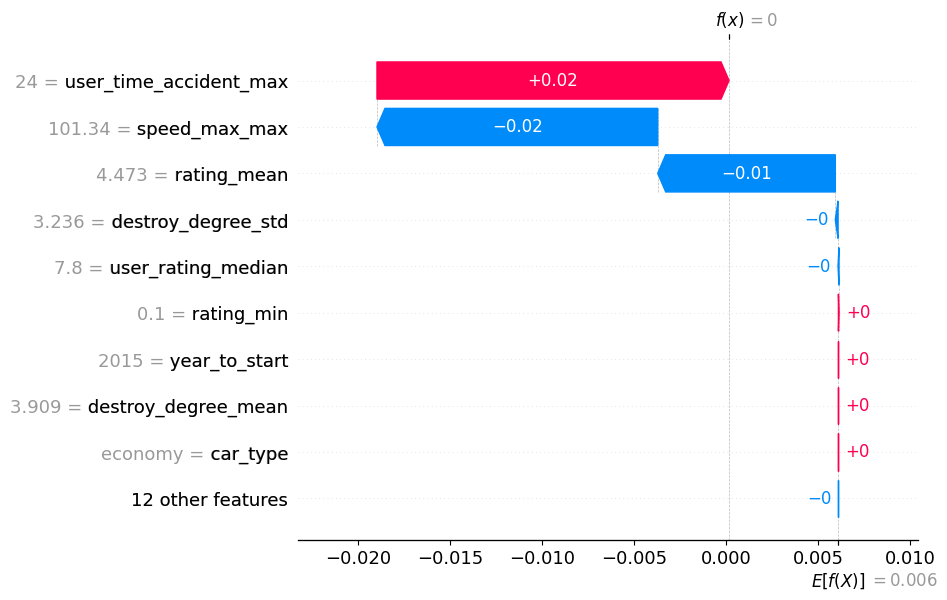

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_pool)
sample_index = 0
class_index = 1

shap_values_single = shap_values[sample_index, :, class_index]
base_value = explainer.expected_value[class_index]

features_single = X_val.iloc[class_index].values
feature_names = X_val.columns

explanation = shap.Explanation(
    values=shap_values_single,
    base_values=base_value,
    data=features_single,
    feature_names=feature_names
)
shap.plots.waterfall(explanation)

---

## Classification report


In [ ]:
cr_df = pd.DataFrame(classification_report(y_true=y_val,
                                           y_pred=y_pred,
                                           target_names=model.classes_,
                                           output_dict=True)).T

cr_df['support'] = cr_df.support.apply(int)
cr_df['precision'] = cr_df.precision.apply(lambda x: round(x, 2))
cr_df['recall'] = cr_df.recall.apply(lambda x: round(x, 2))
cr_df['f1-score'] = cr_df['f1-score'].apply(lambda x: round(x, 2))
cr_df.style.background_gradient(
    cmap='Blues', subset=pd.IndexSlice['another_bug':'wheel_shake', :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.960000,0.940000,0.950000,54
break_bug,1.000000,1.000000,1.000000,57
electro_bug,1.000000,1.000000,1.000000,38
engine_check,1.000000,1.000000,1.000000,53
engine_fuel,0.930000,0.980000,0.960000,56
engine_ignition,1.000000,0.970000,0.980000,58
engine_overheat,0.970000,1.000000,0.980000,64
gear_stick,1.000000,1.000000,1.000000,58
wheel_shake,0.960000,0.900000,0.930000,30
accuracy,0.980000,0.980000,0.980000,0


---

## Confusion Matrix


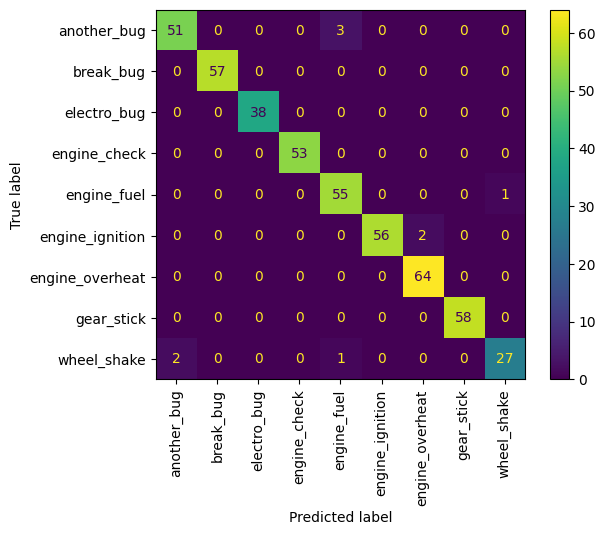

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, xticks_rotation=90)
plt.show()

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna` (10 баллов)


<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.


1. Напишите `objective` функцию и запустите `Optuna` (минимум 50 итераций).
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

<h4> Критерии оценивания </h4>
    
* За корректный `objective` и запуск подбора - 3 балла
* За корректный выбор гиперпараметров для оптимизации - 3 балла
* Обучение модели с подобранными гиперпараметрами - 3 балла
* За корректную работу с логами - 1 балл
    
</div>


In [ ]:
def fit_catboost(trial, train_data, valid_data):

    train_pool = Pool(
        data=train_data[0], label=train_data[1], cat_features=cat_features)
    val_pool = Pool(
        data=valid_data[0], label=valid_data[1], cat_features=cat_features)

    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 100, 400),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.9),

        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 8, 14),
        "eval_metric": "Accuracy",
    }

    clf = CatBoostClassifier(
        **param,
        thread_count=4,
        random_seed=42,
        cat_features=cat_features,
    )

    clf.fit(
        train_pool,
        eval_set=(val_pool),
        verbose=0,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(valid_data[0])
    return clf, y_pred

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import optuna


def objective(trial):
    n_splits = 4
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        model, y_pred = fit_catboost(trial, train_data, valid_data)
        scores.append(accuracy_score(y_pred, valid_data[1]))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

study = optuna.create_study(direction="maximize")
study.optimize(objective,
                n_trials=30,
                n_jobs=4,
                show_progress_bar=True,)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='accuracy_score')

In [ ]:
model = CatBoostClassifier(**study.best_params,
                            thread_count=4,
                            eval_metric="Accuracy",
                            random_seed=42,
                            cat_features=cat_features,
                            verbose=0,
                            early_stopping_rounds=100)
model.fit(train_pool, eval_set=val_pool, plot=True)
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy: {acc:.3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.991


___
## Выводы
- Подбор параметров увеличил метрику с 0,968 (ДЗ2) до 0,991: +2,3 процентных пункта
___

### Общая информация по `Optuna`


#### Ключевые особенности <code>Optuna</code>


- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.


#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции


В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.

```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```


#### `Study` parameters


Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.

```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```


<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)


### Советы по перебору параметров


- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.


# Домашнее задание 4. Блендинг


<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.


1. Построить и обучить модели:

   - `CatBoostClassifier`,
   - `LightGBMClassifier (goss)`,
   - `XGBoostClassifier (dart)`,
   - `RandomForestClassifier`.

2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:

   - `Hard Voting` — метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
   - `Soft Voting` — метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

   Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.

4. Отключайте или минимизируйте логирование (Будут снижаться баллы).

<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>


### Общая информация о блендинге


**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:

- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>


---

## Catboost


In [ ]:
from sklearn.preprocessing import LabelEncoder


def fit_catboost(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    le.fit(y_val)
    y_val_encoded = le.transform(y_val)
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 100),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 0.8),

        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced"]),
        "depth": trial.suggest_int("depth", 8, 16),
        "eval_metric": "AUC",
    }

    clf = CatBoostClassifier(
        **param,
        thread_count=4,
        random_seed=42,
        cat_features=cat_features,
    )

    clf.fit(
        X_train,
        y_train_encoded,
        eval_set=(X_val, y_val_encoded),
        verbose=0,
        plot=False,
        early_stopping_rounds=50,
    )

    y_pred_proba = clf.predict_proba(valid_data[0])
    return clf, y_pred_proba

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import optuna
import joblib


def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_catboost(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
                n_trials=30,
                n_jobs=4,
                show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-12 14:40:59,552] A new study created in memory with name: no-name-b7663690-c91b-4780-a206-213f63a894bb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-12 14:42:39,842] Trial 0 finished with value: 0.9992783245457082 and parameters: {'learning_rate': 0.0020689695533143426, 'l2_leaf_reg': 93, 'colsample_bylevel': 0.3036178389695094, 'auto_class_weights': 'Balanced', 'depth': 10}. Best is trial 0 with value: 0.9992783245457082.
[I 2025-04-12 14:43:10,253] Trial 2 finished with value: 0.9994504163863079 and parameters: {'learning_rate': 0.00822336774840843, 'l2_leaf_reg': 86, 'colsample_bylevel': 0.22003344960906612, 'auto_class_weights': 'Balanced', 'depth': 11}. Best is trial 2 with value: 0.9994504163863079.
[I 2025-04-12 14:44:27,517] Trial 5 finished with value: 0.9996327730617565 and parameters: {'learning_rate': 0.009513919194776132, 'l2_leaf_reg': 13, 'colsample_bylevel': 0.5355972757322591, 'auto_class_weights': 'Balanced', 'depth': 9}. Best is trial 5 with value: 0.9996327730617565.
[I 2025-04-12 14:46:46,679] Trial 1 finished with value: 0.9992952855065436 and parameters: {'learning_rate': 0.005045917156404826, 'l2_

In [ ]:
cb = CatBoostClassifier(**study.best_params,
                        iterations=200,
                        thread_count=4,
                        eval_metric="AUC",
                        random_seed=42,
                        cat_features=cat_features,
                        verbose=0,
                        early_stopping_rounds=50,)
cb.fit(X_train, y_train.to_numpy().ravel(),
        eval_set=(X_val, y_val.to_numpy().ravel()),
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

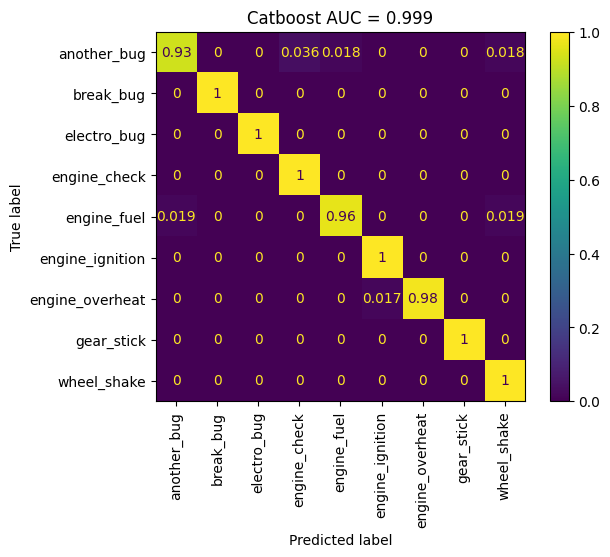

In [ ]:
le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = cb.predict_proba(X_val)
y_pred = cb.predict(X_val)
y_val_pred = y_val.copy()
y_val_pred['target_class'] = pd.DataFrame(
    y_pred.reshape(-1, 1), index=y_val_pred.index)[0]
auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, xticks_rotation=90, normalize='true')
plt.title(f'Catboost AUC = {auc:.3f}')
plt.show()

In [ ]:
import joblib

joblib.dump(cb, 'models/cb.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_cb.pkl')

['models/y_val_pred_cb.pkl']

---

## LGBM


In [ ]:
from lightgbm import LGBMClassifier, Dataset


categorical_features = ['model', 'car_type', 'fuel_type']
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [ ]:
def fit_lgbm(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    le.fit(y_val)
    y_val_encoded = le.transform(y_val)
    param = {
        "objective": "multiclass",
        "num_class": 9,
        "data_sample_strategy": "goss",
        "boosting_type": "goss",
        'n_estimators': trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.015),
        "num_leaves": trial.suggest_int("num_leaves", 15, 55),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 20),
        "verbose": -1,
        "colsample_bytree ": trial.suggest_float("colsample_bytree ", 0.2, 0.9),
        "class_weight ": trial.suggest_categorical("class_weight ", ["Balanced", "None"]),
    }

    clf = LGBMClassifier(
        **param,
        num_threads=4,
        deterministic=True,
        seed=42,
        cat_feature=[0, 1, 2],
    )

    clf.fit(
        X_train,
        y_train_encoded,
        eval_set=(X_val, y_val_encoded),
        eval_metric="logloss"
    )

    y_pred_proba = clf.predict_proba(X_val)
    return clf, y_pred_proba

In [ ]:
def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_lgbm(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=300,
               n_jobs=4,
               show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-12 17:04:31,545] A new study created in memory with name: no-name-22a2a504-1974-4d62-b489-b141727adac4


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-04-12 17:04:35,930] Trial 2 finished with value: 0.9991573128879664 and parameters: {'n_estimators': 170, 'learning_rate': 0.010549714158868285, 'num_leaves': 54, 'reg_alpha': 16.85481108771041, 'reg_lambda': 2.523251300425733, 'colsample_bytree ': 0.7957525600716644, 'class_weight ': 'None'}. Best is trial 2 with value: 0.9991573128879664.
[I 2025-04-12 17:04:36,916] Trial 0 finished with value: 0.998276069303928 and parameters: {'n_estimators': 257, 'learning_rate': 0.005160378112159774, 'num_leaves': 24, 'reg_alpha': 48.75435111210942, 'reg_lambda': 13.652344988731526, 'colsample_bytree ': 0.33932893529734753, 'class_weight ': 'None'}. Best is trial 2 with value: 0.9991573128879664.
[I 2025-04-12 17:04:39,258] Trial 1 finished with value: 0.9990470525488621 and parameters: {'n_estimators': 354, 'learning_rate': 0.006894042381880207, 'num_leaves': 49, 'reg_alpha': 37.42894003907703, 'reg_lambda': 10.367886756034892, 'colsample_bytree ': 0.5003724672186937, 'class_weight ': 'N

In [ ]:
lgb = LGBMClassifier(**study.best_params,
                     eval_metric="logloss",
                     num_threads=4,
                     deterministic=True,
                     seed=42,
                     cat_feature=[0, 1, 2],
                     verbose=-1)
lgb.fit(
    X_train,
    y_train.to_numpy().ravel(),
    eval_set=(X_val, y_val.to_numpy().ravel()),
    eval_metric="logloss"
)

LGBMClassifier(cat_feature=[0, 1, 2], class_weight ='None',
               colsample_bytree =0.5732213645167453, deterministic=True,
               eval_metric='logloss', learning_rate=0.010111051324272004,
               n_estimators=480, num_leaves=20, num_threads=4,
               reg_alpha=8.329500565749099, reg_lambda=0.8429413047266887,
               seed=42, verbose=-1)

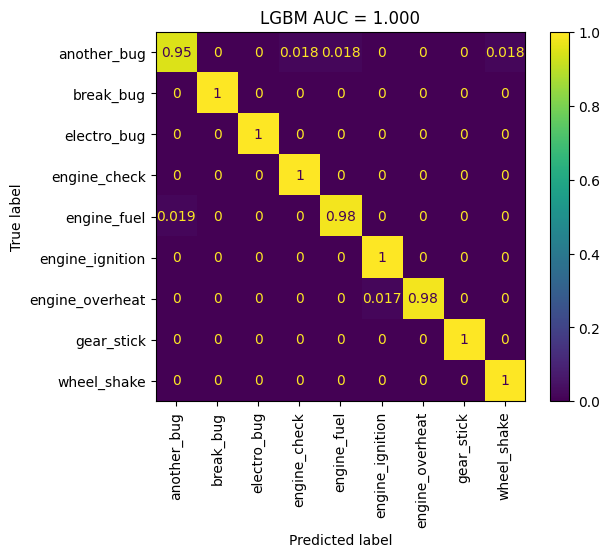

['models/y_val_pred_lgb.pkl']

In [ ]:
le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = lgb.predict_proba(X_val)
y_pred = lgb.predict(X_val)
y_val_pred = y_val.copy()
y_val_pred['target_class'] = pd.DataFrame(
    y_pred.reshape(-1, 1), index=y_val_pred.index)[0]
auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, xticks_rotation=90, normalize='true')
plt.title(f'LGBM AUC = {auc:.3f}')
plt.show()


joblib.dump(lgb, 'models/lgb.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_lgb.pkl')

---

## XGB


In [ ]:
from xgboost import XGBClassifier

In [ ]:
def fit_xgb(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    le.fit(y_val)
    y_val_encoded = le.transform(y_val)

    param = {
        "booster": "dart",
        "enable_categorical": True,
        "eval_metric": "auc",
        "verbosity": 0,
        "objective": "multi:softprob",
        "num_class": 9,
        "eval_metric": "auc",
        "random_state": 42,
        'n_estimators': trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 14),
        "max_leaves": trial.suggest_int("max_leaves", 15, 55),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.015),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 50),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
    }

    clf = XGBClassifier(
        **param,
        n_jobs = 4,
        early_stopping_rounds=30
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val_encoded)],
        verbose=0,
    )

    y_pred_proba = clf.predict_proba(X_val, iteration_range=(1, 20))
    return clf, y_pred_proba

In [ ]:
def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_xgb(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
                n_trials=200,
                n_jobs=4,
                show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-12 17:35:50,215] A new study created in memory with name: no-name-684eb03c-6a3e-40cc-a898-fc1310e32176


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-04-12 17:36:19,257] Trial 2 finished with value: 0.9983516742317455 and parameters: {'n_estimators': 121, 'max_depth': 7, 'max_leaves': 31, 'learning_rate': 0.012026415322628874, 'reg_alpha': 46.631845558844745, 'reg_lambda': 42.887996956089815, 'colsample_bytree': 0.7065861594269799}. Best is trial 2 with value: 0.9983516742317455.
[I 2025-04-12 17:36:23,095] Trial 1 finished with value: 0.9988544182278233 and parameters: {'n_estimators': 162, 'max_depth': 9, 'max_leaves': 24, 'learning_rate': 0.005190349931518266, 'reg_alpha': 18.60362228936152, 'reg_lambda': 43.74222167666652, 'colsample_bytree': 0.7500169818640832}. Best is trial 1 with value: 0.9988544182278233.
[I 2025-04-12 17:36:38,752] Trial 3 finished with value: 0.9988828276791608 and parameters: {'n_estimators': 108, 'max_depth': 11, 'max_leaves': 25, 'learning_rate': 0.009276988706853027, 'reg_alpha': 13.19025622681615, 'reg_lambda': 15.722116653536949, 'colsample_bytree': 0.8782203230262475}. Best is trial 3 with 

In [ ]:
xgb = XGBClassifier(**study.best_params,
                            booster= "dart",
                            enable_categorical= True,
                            verbosity= 0,
                            objective= "multi:softprob",
                            num_class= 9,
                            eval_metric= "auc",
                            random_state= 42,
                            n_jobs = 4,)
le = LabelEncoder()
le.fit(y_train.to_numpy().ravel())
y_train_encoded = le.transform(y_train.to_numpy().ravel())
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

xgb.fit(
    X_train,
    y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    verbose=0
)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7792632908423841, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014730258552071636,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=35,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=4, num_class=9, ...)

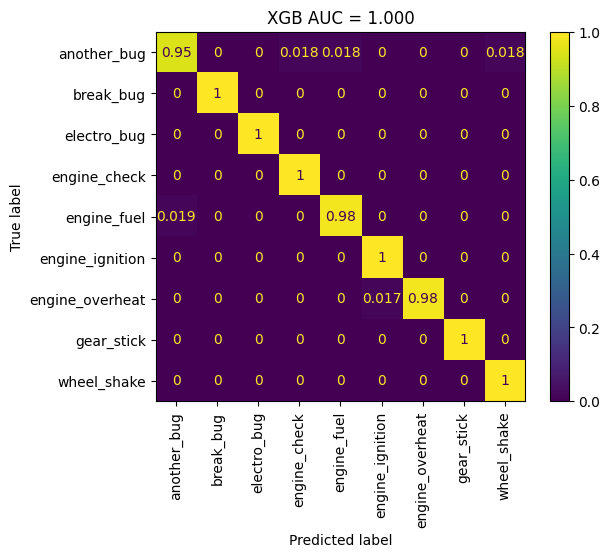

['models/y_val_pred_xgb.pkl']

In [ ]:
le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = xgb.predict_proba(X_val, iteration_range=(1, 20))
y_pred = xgb.predict(X_val, iteration_range=(1, 20))
y_val_pred = y_val.copy()

auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

y_pred_str = le.inverse_transform(y_pred)
y_val_pred['target_class'] = pd.DataFrame(
    y_pred_str.reshape(-1, 1), index=y_val_pred.index)[0]
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_str, xticks_rotation=90, normalize='true')
plt.title(f'XGB AUC = {auc:.3f}')
plt.show()

joblib.dump(xgb, 'models/xgb.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_xgb.pkl')

---

## RandomForest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train_ohe = pd.get_dummies(data=X_train, drop_first=True, dtype=int)
X_val_ohe = pd.get_dummies(data=X_val, drop_first=True, dtype=int)

In [ ]:
def fit_rf(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    param = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 200),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0, 1),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0, 1),
    }

    clf = RandomForestClassifier(
        **param,
        n_jobs = 8,
        random_state=42
    )

    clf.fit(
        X_train,
        y_train_encoded,
    )

    y_pred_proba = clf.predict_proba(X_val)
    return clf, y_pred_proba

In [ ]:
def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train_ohe, y_train):
        train_data = X_train_ohe.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train_ohe.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_rf(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=200,
               n_jobs=8,
               show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-12 18:39:18,986] A new study created in memory with name: no-name-c93f53be-b794-4dda-b962-b9cde2886c18


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-04-12 18:39:30,047] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 125, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.3712842820931004, 'min_impurity_decrease': 0.9107536414944035, 'class_weight': 'balanced', 'ccp_alpha': 0.10126013650174326}. Best is trial 6 with value: 0.5.
[I 2025-04-12 18:39:30,143] Trial 1 finished with value: 0.9426780554848043 and parameters: {'n_estimators': 108, 'criterion': 'log_loss', 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.10280368432308845, 'min_impurity_decrease': 0.696767218353426, 'class_weight': None, 'ccp_alpha': 0.7757532747836696}. Best is trial 1 with value: 0.9426780554848043.
[I 2025-04-12 18:39:30,470] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 136, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.25663590926313

In [ ]:
rf = RandomForestClassifier(**study.best_params,
                            n_jobs = 8,
                            random_state=42)
le = LabelEncoder()
le.fit(y_train.to_numpy().ravel())
y_train_encoded = le.transform(y_train.to_numpy().ravel())
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

rf.fit(
    X_train_ohe,
    y_train_encoded,
)

RandomForestClassifier(ccp_alpha=0.014039765573701242,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=17, min_impurity_decrease=0.000502915141788517,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.03278020940612706,
                       n_estimators=157, n_jobs=8, random_state=42)

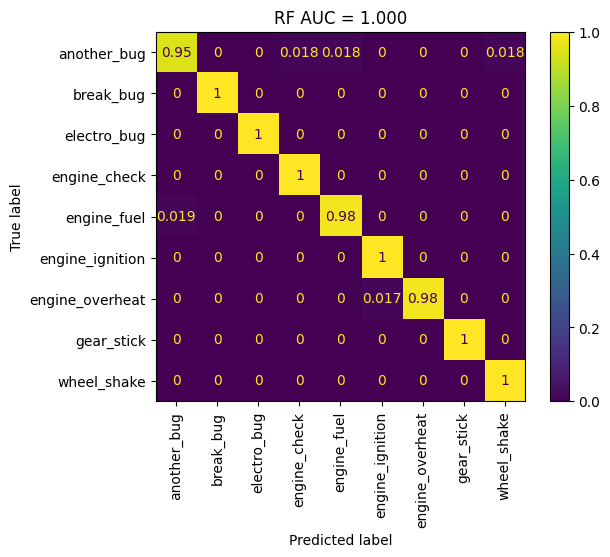

['models/y_val_pred_rf.pkl']

In [ ]:
le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = rf.predict_proba(X_val_ohe)
y_pred = rf.predict(X_val_ohe)
y_val_pred = y_val.copy()

auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

y_pred_str = le.inverse_transform(y_pred)
y_val_pred['target_class'] = pd.DataFrame(
    y_pred_str.reshape(-1, 1), index=y_val_pred.index)[0]
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_str, xticks_rotation=90, normalize='true')
plt.title(f'RF AUC = {auc:.3f}')
plt.show()

joblib.dump(rf, 'models/rf.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_rf.pkl')

---

## Blending


In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder


cb = joblib.load('models/cb.pkl')
lgb = joblib.load('models/lgb.pkl')
xgb = joblib.load('models/xgb.pkl')
rf = joblib.load('models/rf.pkl')

le = LabelEncoder()
le.fit(y_train.to_numpy().ravel())

categorical_features = ['model', 'car_type', 'fuel_type']
for col in categorical_features:
    X_val[col] = X_val[col].astype('category')

In [ ]:
y_pred_lgb = lgb.predict(X_val)
y_pred_cb = cb.predict(X_val).ravel()
y_pred_xgb = le.inverse_transform(xgb.predict(X_val))
y_pred_rf = le.inverse_transform(rf.predict(X_val_ohe))

all_preds_np = np.stack((y_pred_lgb,y_pred_cb, y_pred_xgb, y_pred_rf), axis=1)
all_preds_df = pd.DataFrame(all_preds_np, columns=(
    'lgb',
    'cb',
    'xgb',
    'rf'
    ))

def get_vote(row: pd.Series):
    votes = row.mode()

    if len(votes) == 1:
        return votes.iloc[0]
    elif len(votes) > 1:
        for val in row:
            if val in votes.values:
                return val


all_preds_df['hard'] = all_preds_df.apply(get_vote, axis=1)

In [ ]:
y_pred_proba_cb = cb.predict_proba(X_val)
y_pred_proba_lgb = lgb.predict_proba(X_val)
y_pred_proba_xgb = xgb.predict_proba(X_val)
y_pred_proba_rf = rf.predict_proba(X_val_ohe)

soft_vote_prob = (y_pred_proba_lgb + y_pred_proba_cb + y_pred_proba_xgb + y_pred_proba_rf)
soft_vote = le.inverse_transform(soft_vote_prob.argmax(axis=1))

all_preds_df['soft'] = soft_vote

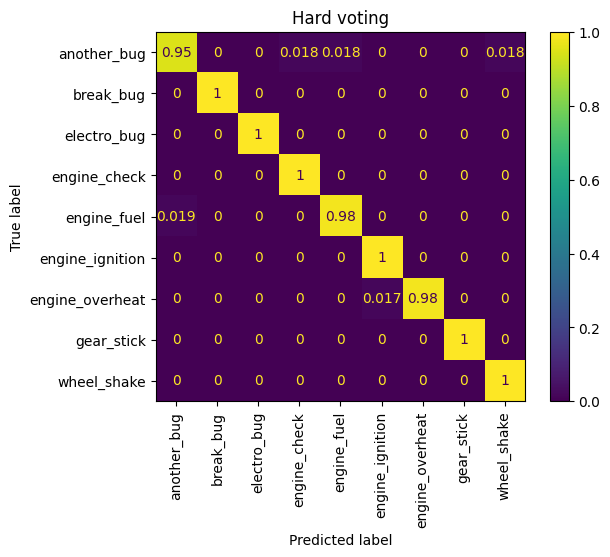

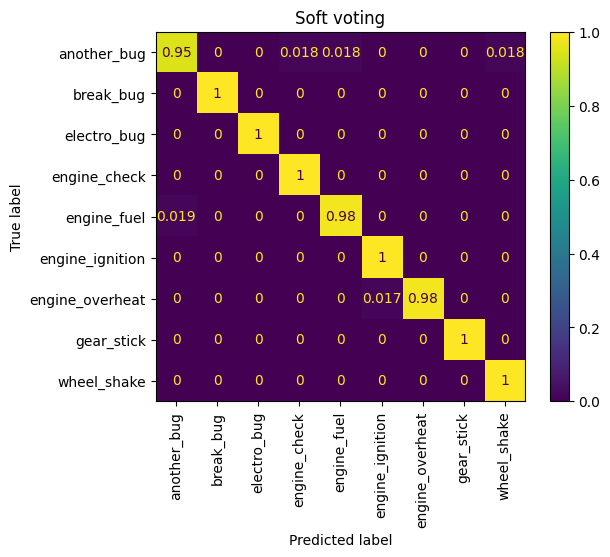

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_val, all_preds_df['hard'], xticks_rotation=90, normalize='true')
plt.title("Hard voting")
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_val, all_preds_df['soft'], xticks_rotation=90, normalize='true')
plt.title("Soft voting")
plt.show()


# <center id="part6"> Отправка финального решения на лидерборд на Kaggle


<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).


1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>


In [ ]:
car_test = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


### Советы по отправке кода на Kaggle


Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.


In [ ]:
rides_info['rating_min'] = rides_info.groupby(
    'car_id')['rating'].transform('min')
rides_info['rating_mean'] = rides_info.groupby(
    'car_id')['rating'].transform('mean')
rides_info['distance_sum'] = rides_info.groupby(
    'car_id')['distance'].transform('sum')
rides_info['speed_max_max'] = rides_info.groupby(
    'car_id')['speed_max'].transform('max')
rides_info['rides_count'] = rides_info.groupby(
    'car_id')['ride_id'].transform('count')
rides_info['ride_duration_sum'] = rides_info.groupby(
    'car_id')['ride_duration'].transform('sum')
rides_info['user_ride_quality_mean'] = rides_info.groupby(
    'car_id')['user_ride_quality'].transform('mean')
rides_info['deviation_normal_median'] = rides_info.groupby(
    'car_id')['deviation_normal'].transform('median')

df_rides_info = rides_info[[
    'car_id',
    'rating_min',
    'rating_mean',
    'distance_sum',
    'speed_max_max',
    'rides_count',
    'ride_duration_sum',
    'user_ride_quality_mean',
    'deviation_normal_median']].drop_duplicates()

df = pd.merge(left=car_test, right=df_rides_info, on='car_id', how='left')

In [ ]:
fix_info['destroy_degree_mean'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('mean')
fix_info['work_duration_sum'] = fix_info.groupby(
    'car_id')['work_duration'].transform('sum')
fix_info['destroy_degree_std'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('std')

df_fix_info = fix_info[[
    'car_id',
    'destroy_degree_mean',
    'work_duration_sum',
    'destroy_degree_std']].drop_duplicates()

In [ ]:
df_driver_info = driver_info[['user_id', 'age',
                              'user_time_accident', 'user_rating']]

df_driver_rides = pd.merge(
    left=rides_info, right=df_driver_info, on='user_id', how='left')

df_driver_rides['age_mean'] = df_driver_rides.groupby('car_id')[
    'age'].transform('mean')
df_driver_rides['user_time_accident_max'] = df_driver_rides.groupby(
    'car_id')['user_time_accident'].transform('max')
df_driver_rides['user_rating_median'] = df_driver_rides.groupby(
    'car_id')['user_rating'].transform('median')

df_driver_rides_info = df_driver_rides[[
    'car_id',
    'age_mean',
    'user_time_accident_max',
    'user_rating_median'
]].drop_duplicates()

In [ ]:
df = pd.merge(left=df, right=df_driver_rides_info, on='car_id', how='left')
df = pd.merge(left=df, right=df_fix_info, on='car_id', how='left')

In [ ]:
features2drop = ['car_id']  # то, что надо выбросить

cat_features = ['model', 'car_type', 'fuel_type']  # категориальные признаки

num_features = ['car_rating',
                'year_to_start',
                'riders',
                'year_to_work',
                'rating_min',
                'rating_mean',
                'distance_sum',
                'speed_max_max',
                'rides_count',
                'ride_duration_sum',
                'user_ride_quality_mean',
                'deviation_normal_median',
                'age_mean',
                'user_time_accident_max',
                'user_rating_median',
                'destroy_degree_mean',
                'work_duration_sum',
                'destroy_degree_std',
                ]  # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)

X_test = df.drop(features2drop, axis=1)[cat_features+num_features]


Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 18 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'rides_count', 'ride_duration_sum', 'user_ride_quality_mean', 'deviation_normal_median', 'age_mean', 'user_time_accident_max', 'user_rating_median', 'destroy_degree_mean', 'work_duration_sum', 'destroy_degree_std']


In [ ]:
le = LabelEncoder()
le.fit(y_train.to_numpy().ravel())

categorical_features = ['model', 'car_type', 'fuel_type']
for col in categorical_features:
    X_test[col] = X_test[col].astype('category')

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   model                    1913 non-null   category
 1   car_type                 1913 non-null   category
 2   fuel_type                1913 non-null   category
 3   car_rating               1913 non-null   float64 
 4   year_to_start            1913 non-null   int64   
 5   riders                   1913 non-null   int64   
 6   year_to_work             1913 non-null   int64   
 7   rating_min               1913 non-null   float64 
 8   rating_mean              1913 non-null   float64 
 9   distance_sum             1913 non-null   float64 
 10  speed_max_max            1913 non-null   float64 
 11  rides_count              1913 non-null   int64   
 12  ride_duration_sum        1913 non-null   int64   
 13  user_ride_quality_mean   1913 non-null   float64 
 14  deviatio

In [ ]:
y_pred_test_lgb = lgb.predict(X_test)
y_pred_test_cb = cb.predict(X_test).ravel()
y_pred_test_xgb = le.inverse_transform(xgb.predict(X_test))


all_preds_test_np = np.stack((y_pred_test_lgb,y_pred_test_cb, y_pred_test_xgb), axis=1)
all_preds_test_df = pd.DataFrame(all_preds_test_np, columns=(
    'lgb',
    'cb',
    'xgb',
    ))

y_pred_test_proba_lgb = lgb.predict_proba(X_test)
y_pred_test_proba_cb = cb.predict_proba(X_test)
y_pred_test_proba_xgb = xgb.predict_proba(X_test)


soft_vote_prob = (y_pred_test_proba_lgb + y_pred_test_proba_cb + y_pred_test_proba_xgb )
soft_vote = le.inverse_transform(soft_vote_prob.argmax(axis=1))

all_preds_test_df['soft'] = soft_vote

In [ ]:
all_preds_test_df

,lgb,cb,xgb,soft
0,engine_overheat,engine_overheat,engine_overheat,engine_overheat
1,electro_bug,electro_bug,electro_bug,electro_bug
2,break_bug,break_bug,break_bug,break_bug
3,gear_stick,gear_stick,gear_stick,gear_stick
4,electro_bug,electro_bug,electro_bug,electro_bug
...,...,...,...,...
1908,engine_check,engine_check,engine_check,engine_check
1909,engine_overheat,engine_overheat,engine_overheat,engine_overheat
1910,gear_stick,gear_stick,gear_stick,gear_stick
1911,engine_check,engine_check,engine_check,engine_check


In [ ]:
submit_csv = all_preds_test_df[['soft']].copy()
submit_csv.loc[:, 'car_id'] = car_test['car_id']
submit_csv.loc[:, 'target_class'] = submit_csv['soft']
submit_csv = submit_csv.drop(columns=['soft'])

submit_csv.to_csv('submit/submit2_csv.csv', index=False)

# Домашнее задание 5. Парсинг данных


**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:

- Jupiter Notebook с кодом.
- Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

- Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
- Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
- Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
- Получилось спарсить ссылки на модели автомобилей — 4 балла.
- Код не исполняется; нет датасета — 1 балл.


## <center> Разминаемся

В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html


Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >


In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm import tqdm


URL = 'https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html'
page = requests.get(URL)
page.encoding = 'utf-8'

In [ ]:
html_parsed = BeautifulSoup(page.text, "html.parser")
cities = html_parsed.find_all('div',  class_='row block_rating')

result = []
for city in cities:
    city_result = {}
    city_result['city'] = city.find('div', class_='reg_name').text
    city_result['mean_salary'] = int(city.find('span', class_='reg_salary').text.replace('₽', '').replace('\xa0', ''))
    result.append(city_result)

city_df = pd.DataFrame(result)
city_df = city_df.sort_values(by='city').reset_index(drop=True)
city_df

,city,mean_salary
0,Абакан,45300
1,Анадырь,129200
2,Ангарск,45600
3,Архангельск,53100
4,Астрахань,38000
...,...,...
95,Чита,47500
96,Элиста,31700
97,Южно-Сахалинск,99000
98,Якутск,74400


## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >


## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1. Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2. Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >


В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >


Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >


In [ ]:
URL = 'https://automobili.ru/cars/catalog/'
page = requests.get(URL)
page.encoding = 'utf-8'

In [ ]:
html_parsed = BeautifulSoup(page.text, "html.parser")
brends = html_parsed.find_all('div', class_='cell small-6 medium-20p')
domain = 'https://automobili.ru'

result_models = []
for brend in tqdm(brends, desc='Parsing brends'):
    brend_link = brend.find('a', class_='car-brand-link')['href']
    brend_name = brend.find('div', class_='car-brand-link__title').text
    brend_link_inner = domain + brend_link

    brend_page = requests.get(brend_link_inner)
    brend_page.encoding = 'utf-8'

    brend_page_parsed = BeautifulSoup(brend_page.text, "html.parser")
    models = brend_page_parsed.find_all('a', class_='model-item__title')


    for model in models:
        models_dict = {}
        models_dict['link'] = domain + model['href']
        models_dict['model'] = brend_name + ' ' + model.text
        result_models.append(models_dict)

parsed_cars_df = pd.DataFrame(result_models).reset_index(drop=True)
parsed_cars_df = parsed_cars_df.sort_values(by=['model', 'link'])

parsed_cars_df

Parsing brends: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]


,link,model
1,https://automobili.ru/cars/catalog/aston_marti...,Aston Martin DB11
2,https://automobili.ru/cars/catalog/aston_marti...,Aston Martin DBS Superleggera
0,https://automobili.ru/cars/catalog/aston_marti...,Aston Martin Vantage
3,https://automobili.ru/cars/catalog/audi/a3/,Audi A3
4,https://automobili.ru/cars/catalog/audi/a4/,Audi A4
...,...,...
319,https://automobili.ru/cars/catalog/gas/sobol-b...,ГАЗ Соболь Бизнес
324,https://automobili.ru/cars/catalog/uaz/bukhanka/,"УАЗ ""Буханка"""
322,https://automobili.ru/cars/catalog/uaz/patriot/,УАЗ Патриот
323,https://automobili.ru/cars/catalog/uaz/pickup/,УАЗ Пикап


## <center> Матчим ссылки с датасетом

Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.


In [339]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >


Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1. Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2. Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3. Отсечь те случаи, где нормализованное значение меньше 0.85.

4. Если не удалось найти матч - заполняем np.nan.

P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.


Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >


In [ ]:
from difflib import SequenceMatcher


df['model'] = df['model'].apply(lambda x: x.replace('VW', 'Volkswagen') if x.startswith('VW') else x)

def lcs(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).find_longest_match(0, len(a), 0, len(b)).size / len(a)

result_matching = []
for row_orig in tqdm(df.iterrows(), total=len(df)):
    orig_dict = {}
    model_orig = row_orig[1]['model']
    orig_dict['model_orig'] = model_orig

    best_score = 0
    best_candidate = np.nan
    link_pars = np.nan
    for row_pars in parsed_cars_df.iterrows():
        model_pars = row_pars[1]['model']

        score = lcs(model_orig, model_pars)
        if score > best_score and score >= 0.85:
            best_score = score
            best_candidate = model_pars
            link_pars = row_pars[1]['link']

    orig_dict['model_pars'] = best_candidate
    orig_dict['score'] = best_score
    orig_dict['link_pars'] = link_pars

    result_matching.append(orig_dict)

match_df = pd.DataFrame(result_matching)
match_df

100%|██████████| 2337/2337 [00:34<00:00, 67.31it/s]


,model_orig,model_pars,score,link_pars
0,Kia Rio X-line,NaN,0.0,NaN
1,Volkswagen Polo VI,NaN,0.0,NaN
2,Renault Sandero,Renault Sandero,1.0,https://automobili.ru/cars/catalog/renault/san...
3,Mercedes-Benz GLC,Mercedes-Benz GLC,1.0,https://automobili.ru/cars/catalog/mercedes-be...
4,Renault Sandero,Renault Sandero,1.0,https://automobili.ru/cars/catalog/renault/san...
...,...,...,...,...
2332,Smart ForFour,smart Forfour,1.0,https://automobili.ru/cars/catalog/smart/forfour/
2333,Audi A4,Audi A4,1.0,https://automobili.ru/cars/catalog/audi/a4/
2334,Kia Rio,Kia Rio,1.0,https://automobili.ru/cars/catalog/kia/rio_new/
2335,Renault Sandero,Renault Sandero,1.0,https://automobili.ru/cars/catalog/renault/san...


## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >


Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;

Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.


Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >


In [ ]:
results_lst = []
for row in tqdm(match_df.iterrows(), total=len(match_df)):
    link = row[1]['link_pars']
    model_orig = row[1]['model_orig']
    if isinstance(link, str):
        page = requests.get(link)
        page.encoding = 'utf-8'
        html_parsed = BeautifulSoup(page.text, "html.parser")

        result = {}
        result['model'] = model_orig
        try:
            result['year'] = int(html_parsed.find('h1', class_='h1 h1--secondary').text[-4:])
        except ValueError:
            result['year'] = int(html_parsed.find('h1', class_='h1 h1--secondary').text[-17: -13])

        all_td = html_parsed.find('table', class_='modifications-table modifications__table hover unstriped').find('tbody').find('tr').find_all('td')

        counter = 0
        for i in all_td:
            if counter == 1:
                result['mod'] = i.text
            elif counter == 2:
                result['price'] = int(i.text.replace('₽', '').replace('\xa0', '').replace('от ', '').replace(' ', '').strip())
            elif counter == 3:
                result['engine'] = i.text
            elif counter == 4:
                result['power'] = int(i.text.replace(' л.с.', ''))
            elif counter == 5:
                result['box'] = i.text
            elif counter == 6:
                result['trans'] = i.text
            elif counter == 7:
                result['body'] = i.text
            counter +=1

        results_lst.append(result)

100%|██████████| 2337/2337 [07:54<00:00,  4.92it/s]


In [341]:
new_df = pd.DataFrame(results_lst)

merged_df = pd.merge(left=df, right=new_df, how='left', on='model')
merged_df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,deviation_normal_count,user_uniq,year,mod,price,engine,power,box,trans,body
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,...,174,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O41613818T,Volkswagen Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,...,174,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,...,174,173,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
3,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,...,174,173,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
4,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,...,174,173,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252272,z-1337463D,Volkswagen Polo,economy,petrol,3.94,2015,92312,2016,54.31,engine_check,...,174,173,2020.0,1.6 5MT Origin,877900.0,Бензин,90.0,Механическая,Передний,Лифтбэк
252273,z-1337463D,Volkswagen Polo,economy,petrol,3.94,2015,92312,2016,54.31,engine_check,...,174,173,2020.0,1.6 5MT Origin,877900.0,Бензин,90.0,Механическая,Передний,Лифтбэк
252274,z-1337463D,Volkswagen Polo,economy,petrol,3.94,2015,92312,2016,54.31,engine_check,...,174,173,2020.0,1.6 5MT Origin,877900.0,Бензин,90.0,Механическая,Передний,Лифтбэк
252275,z-1337463D,Volkswagen Polo,economy,petrol,3.94,2015,92312,2016,54.31,engine_check,...,174,173,2020.0,1.6 5MT Origin,877900.0,Бензин,90.0,Механическая,Передний,Лифтбэк


In [343]:
merged_df.to_csv('data/parsing_data/merged_df.csv', index=False)

## <center> Тренировка с новыми данными


Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = ['car_id', 'target_reg',
                 'target_class']
targets = ['target_class']
cat_features = ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
num_features = [
    'car_rating',
    'year_to_start',
    'riders',
    'year_to_work',
    'mean_rating',
    'distance_sum',
    'rating_min',
    'speed_max',
    'user_ride_quality_median',
    'deviation_normal_count',
    'user_uniq',
    'year',
    'price',
    'power'
                ]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 8 ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
Числовые признаки: 14 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'year', 'price', 'power']
Целевые переменные ['target_class']


In [ ]:
merged_df = merged_df.fillna(0)

X = merged_df.drop(features2drop, axis=1)[cat_features+num_features]
Y = merged_df[targets]

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=merged_df[['car_type', 'fuel_type', 'target_class']])
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
from lightgbm import LGBMClassifier, Dataset
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [ ]:
def fit_lgbm(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    le.fit(y_val)
    y_val_encoded = le.transform(y_val)
    param = {
        'device_type': 'gpu',
        "objective": "multiclass",
        "num_class": 9,
        "data_sample_strategy": "goss",
        "boosting_type": "goss",
        'n_estimators': trial.suggest_int("n_estimators", 250, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.015),
        "num_leaves": trial.suggest_int("num_leaves", 15, 55),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 20),
        "verbose": -1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        "class_weight": trial.suggest_categorical("class_weight", ["Balanced", None]),
    }

    clf = LGBMClassifier(
        **param,
        num_threads=4,
        deterministic=True,
        seed=42,
        # cat_feature=[0, 1, 2],
    )

    clf.fit(
        X_train,
        y_train_encoded,
        eval_set=(X_val, y_val_encoded),
        eval_metric="logloss"
    )

    y_pred_proba = clf.predict_proba(X_val)
    return clf, y_pred_proba

In [ ]:
def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_lgbm(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=30,
               n_jobs=4,
               show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-21 12:14:12,004] A new study created in memory with name: no-name-c3655cb7-24f7-4df5-8107-e77942b0b054


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-21 12:20:41,862] Trial 0 finished with value: 0.9999728411007404 and parameters: {'n_estimators': 565, 'learning_rate': 0.011588165052607506, 'num_leaves': 20, 'reg_alpha': 44.42401430298156, 'reg_lambda': 4.098809289016434, 'colsample_bytree ': 0.22833494378229957, 'class_weight ': 'Balanced'}. Best is trial 0 with value: 0.9999728411007404.
[I 2025-04-21 12:21:43,700] Trial 3 finished with value: 0.999973923525966 and parameters: {'n_estimators': 548, 'learning_rate': 0.010419391027649404, 'num_leaves': 24, 'reg_alpha': 46.817934747762955, 'reg_lambda': 17.922474778169104, 'colsample_bytree ': 0.3466179763607161, 'class_weight ': 'None'}. Best is trial 3 with value: 0.999973923525966.
[I 2025-04-21 12:24:16,736] Trial 2 finished with value: 0.9999853405782241 and parameters: {'n_estimators': 574, 'learning_rate': 0.009609803427217846, 'num_leaves': 36, 'reg_alpha': 13.451224805381829, 'reg_lambda': 18.56425882619043, 'colsample_bytree ': 0.689836016279108, 'class_weight ':

In [ ]:
lgb = LGBMClassifier(**study.best_params,
                     eval_metric="logloss",
                     num_threads=4,
                     deterministic=True,
                     seed=42,
                     verbose=-1)
lgb.fit(
    X_train,
    y_train.to_numpy().ravel(),
    eval_set=(X_val, y_val.to_numpy().ravel()),
    eval_metric="logloss"
)

LGBMClassifier(class_weight ='None', colsample_bytree =0.560041291631671,
               deterministic=True, eval_metric='logloss',
               learning_rate=0.014535197545730441, n_estimators=476,
               num_leaves=47, num_threads=4, reg_alpha=0.05184700912147422,
               reg_lambda=8.445630842046358, seed=42, verbose=-1)

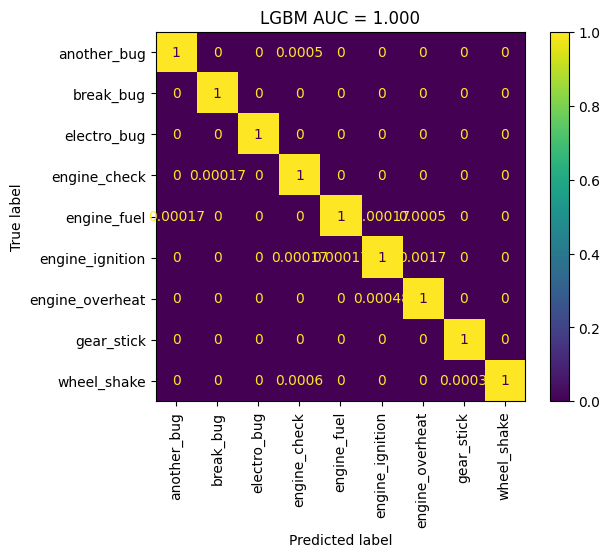

['models/y_val_pred_lgb_merged.pkl']

In [ ]:
import joblib


le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = lgb.predict_proba(X_val)
y_pred = lgb.predict(X_val)
y_val_pred = y_val.copy()
y_val_pred['target_class'] = pd.DataFrame(
    y_pred.reshape(-1, 1), index=y_val_pred.index)[0]
auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, xticks_rotation=90, normalize='true')
plt.title(f'LGBM AUC = {auc:.3f}')
plt.show()


joblib.dump(lgb, 'models/lgb_merged.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_lgb_merged.pkl')

___
___
## DataFrame с моими признаками

In [240]:
new_df = pd.DataFrame(results_lst)

merged_df = pd.merge(left=df, right=new_df, how='left', on='model')
merged_df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,work_duration_sum,destroy_degree_std,year,mod,price,engine,power,box,trans,body
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,933,2.732847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,873,2.707233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,915,2.978077,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
3,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,915,2.978077,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
4,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,915,2.978077,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214442,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,857,2.899751,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
214443,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,857,2.899751,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
214444,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,857,2.899751,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек
214445,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,857,2.899751,2018.0,1.6 5MT Access,697000.0,Бензин,82.0,Механическая,Передний,Хэтчбек


In [241]:
features2drop = ['car_id', 'target_reg',
                 'target_class']
targets = ['target_class']
cat_features = ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
num_features = [
    'car_rating',
    'year_to_start',
    'riders',
    'year_to_work',
    'distance_sum',
    'rating_min',
    'rating_mean',
    'speed_max_max',
    'rides_count',
    'ride_duration_sum',
    'user_ride_quality_mean',
    'deviation_normal_median',
    'user_time_accident_max',
    'user_rating_median',
    'destroy_degree_mean',
    'work_duration_sum',
    'destroy_degree_std',
    'age_mean',
    'year',
    'price',
    'power'
                ]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 8 ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
Числовые признаки: 21 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'distance_sum', 'rating_min', 'rating_mean', 'speed_max_max', 'rides_count', 'ride_duration_sum', 'user_ride_quality_mean', 'deviation_normal_median', 'user_time_accident_max', 'user_rating_median', 'destroy_degree_mean', 'work_duration_sum', 'destroy_degree_std', 'age_mean', 'year', 'price', 'power']
Целевые переменные ['target_class']


In [242]:
merged_df = merged_df.fillna(0)

X = merged_df.drop(features2drop, axis=1)[cat_features+num_features]
Y = merged_df[targets]

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=merged_df[['car_type', 'fuel_type', 'target_class']])
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(171557, 29) (42890, 29) (171557, 1) (42890, 1)


In [243]:
from lightgbm import LGBMClassifier, Dataset
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [ ]:
def fit_lgbm(trial, train_data, valid_data):

    X_train, y_train = train_data
    X_val, y_val = valid_data

    le = LabelEncoder()
    le.fit(y_train)
    y_train_encoded = le.transform(y_train)

    le.fit(y_val)
    y_val_encoded = le.transform(y_val)
    param = {
        'device_type': 'gpu',
        "objective": "multiclass",
        "num_class": 9,
        "data_sample_strategy": "goss",
        "boosting_type": "goss",
        'n_estimators': trial.suggest_int("n_estimators", 250, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.02),
        "num_leaves": trial.suggest_int("num_leaves",30, 70),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "verbose": -1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.5),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "None"]),
    }

    clf = LGBMClassifier(
        **param,
        num_threads=4,
        deterministic=True,
        seed=42,
        # cat_feature=[0, 1, 2],
    )

    clf.fit(
        X_train,
        y_train_encoded,
        eval_set=(X_val, y_val_encoded),
        eval_metric="logloss"
    )

    y_pred_proba = clf.predict_proba(X_val)
    return clf, y_pred_proba

In [267]:
def objective(trial):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores, models = [], []

    le = LabelEncoder()
    le.fit(y_train.to_numpy().ravel())
    Y_encoded = le.transform(y_train.to_numpy().ravel())
    for train_idx, valid_idx in skf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx, :], Y_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], Y_encoded[valid_idx]

        model, y_pred_proba = fit_lgbm(trial, train_data, valid_data)
        scores.append(roc_auc_score(
            valid_data[1], y_pred_proba, multi_class='ovo'))
        models.append(model)

    result = np.mean(scores) - np.std(scores)

    return result

In [268]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=30,
               n_jobs=4,
               show_progress_bar=True,)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study,
                                target_name='AUC')

[I 2025-04-21 14:49:50,316] A new study created in memory with name: no-name-fab57c60-85d3-4dfd-8e5c-0a4136489885


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-21 14:58:05,490] Trial 1 finished with value: 0.9999999663661393 and parameters: {'n_estimators': 531, 'learning_rate': 0.010288096776316726, 'num_leaves': 30, 'reg_alpha': 4.930385875100094, 'reg_lambda': 1.5188727594056262, 'colsample_bytree': 0.43158003558054786, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9999999663661393.
[I 2025-04-21 15:01:06,673] Trial 0 finished with value: 0.9999999336091544 and parameters: {'n_estimators': 597, 'learning_rate': 0.007372829347668479, 'num_leaves': 49, 'reg_alpha': 3.583226606358814, 'reg_lambda': 5.285390311808344, 'colsample_bytree': 0.49882551959071664, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9999999663661393.
[I 2025-04-21 15:03:09,731] Trial 2 finished with value: 0.999999891721063 and parameters: {'n_estimators': 335, 'learning_rate': 0.01103136340689939, 'num_leaves': 61, 'reg_alpha': 0.6712623797464873, 'reg_lambda': 5.126343610073887, 'colsample_bytree': 0.22654305320078832, 'class_weight':

In [327]:
lgb = LGBMClassifier(**study.best_params,
                    device_type='gpu',
                    objective= "multiclass",
                    num_class= 9,
                    data_sample_strategy= "goss",
                    boosting_type= "goss",
                    eval_metric="logloss",
                    num_threads=4,
                    deterministic=True,
                    seed=42,
                    verbose=-1)
lgb.fit(
    X_train,
    y_train.to_numpy().ravel(),
    eval_set=(X_val, y_val.to_numpy().ravel()),
    eval_metric="logloss"
)

LGBMClassifier(boosting_type='goss', colsample_bytree=0.2628121572559988,
               data_sample_strategy='goss', deterministic=True,
               device_type='gpu', eval_metric='logloss',
               learning_rate=0.01613256368590002, n_estimators=595, num_class=9,
               num_leaves=60, num_threads=4, objective='multiclass',
               reg_alpha=3.76006968041321, reg_lambda=9.524415834062529,
               seed=42, verbose=-1)

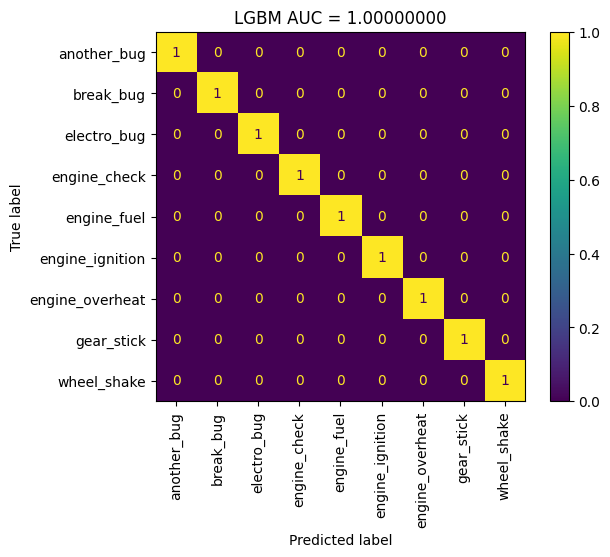

['models/y_val_pred_lgb_merged.pkl']

In [338]:
import joblib


le = LabelEncoder()
le.fit(y_val.to_numpy().ravel())
y_val_encoded = le.transform(y_val.to_numpy().ravel())

y_pred_proba = lgb.predict_proba(X_val)
y_pred = lgb.predict(X_val)
y_val_pred = y_val.copy()
y_val_pred['target_class'] = pd.DataFrame(
    y_pred.reshape(-1, 1), index=y_val_pred.index)[0]
auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovo')

ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, xticks_rotation=90, normalize='true')
plt.title(f'LGBM AUC = {auc:.8f}')
plt.show()


joblib.dump(lgb, 'models/lgb_merged.pkl')
joblib.dump(y_val_pred, 'models/y_val_pred_lgb_merged.pkl')

In [329]:
car_test = pd.read_csv(
    'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [330]:
rides_info['rating_min'] = rides_info.groupby(
    'car_id')['rating'].transform('min')
rides_info['rating_mean'] = rides_info.groupby(
    'car_id')['rating'].transform('mean')
rides_info['distance_sum'] = rides_info.groupby(
    'car_id')['distance'].transform('sum')
rides_info['speed_max_max'] = rides_info.groupby(
    'car_id')['speed_max'].transform('max')
rides_info['rides_count'] = rides_info.groupby(
    'car_id')['ride_id'].transform('count')
rides_info['ride_duration_sum'] = rides_info.groupby(
    'car_id')['ride_duration'].transform('sum')
rides_info['user_ride_quality_mean'] = rides_info.groupby(
    'car_id')['user_ride_quality'].transform('mean')
rides_info['deviation_normal_median'] = rides_info.groupby(
    'car_id')['deviation_normal'].transform('median')

df_rides_info = rides_info[[
    'car_id',
    'rating_min',
    'rating_mean',
    'distance_sum',
    'speed_max_max',
    'rides_count',
    'ride_duration_sum',
    'user_ride_quality_mean',
    'deviation_normal_median']].drop_duplicates()

df = pd.merge(left=car_test, right=df_rides_info, on='car_id', how='left')

In [331]:
fix_info['destroy_degree_mean'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('mean')
fix_info['work_duration_sum'] = fix_info.groupby(
    'car_id')['work_duration'].transform('sum')
fix_info['destroy_degree_std'] = fix_info.groupby(
    'car_id')['destroy_degree'].transform('std')

df_fix_info = fix_info[[
    'car_id',
    'destroy_degree_mean',
    'work_duration_sum',
    'destroy_degree_std']].drop_duplicates()

In [332]:
df_driver_info = driver_info[['user_id', 'age',
                              'user_time_accident', 'user_rating']]

df_driver_rides = pd.merge(
    left=rides_info, right=df_driver_info, on='user_id', how='left')

df_driver_rides['age_mean'] = df_driver_rides.groupby('car_id')[
    'age'].transform('mean')
df_driver_rides['user_time_accident_max'] = df_driver_rides.groupby(
    'car_id')['user_time_accident'].transform('max')
df_driver_rides['user_rating_median'] = df_driver_rides.groupby(
    'car_id')['user_rating'].transform('median')

df_driver_rides_info = df_driver_rides[[
    'car_id',
    'age_mean',
    'user_time_accident_max',
    'user_rating_median'
]].drop_duplicates()

In [333]:
df = pd.merge(left=df, right=df_driver_rides_info, on='car_id', how='left')
df = pd.merge(left=df, right=df_fix_info, on='car_id', how='left')
df = pd.merge(left=df, right=new_df, how='left', on='model')
df = df.drop_duplicates()

In [334]:
features2drop = ['car_id']

cat_features = ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
num_features = [
    'car_rating',
    'year_to_start',
    'riders',
    'year_to_work',
    'distance_sum',
    'rating_min',
    'rating_mean',
    'speed_max_max',
    'rides_count',
    'ride_duration_sum',
    'user_ride_quality_mean',
    'deviation_normal_median',
    'user_time_accident_max',
    'user_rating_median',
    'destroy_degree_mean',
    'work_duration_sum',
    'destroy_degree_std',
    'age_mean',
    'year',
    'price',
    'power'
                ]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)

X_test = df.drop(features2drop, axis=1)[cat_features+num_features]

Категориальные признаки: 8 ['model', 'car_type', 'fuel_type', 'mod', 'engine', 'box', 'trans', 'body']
Числовые признаки: 21 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'distance_sum', 'rating_min', 'rating_mean', 'speed_max_max', 'rides_count', 'ride_duration_sum', 'user_ride_quality_mean', 'deviation_normal_median', 'user_time_accident_max', 'user_rating_median', 'destroy_degree_mean', 'work_duration_sum', 'destroy_degree_std', 'age_mean', 'year', 'price', 'power']


In [335]:
for col in cat_features:
    X_test[col] = X_test[col].astype('category')

In [ ]:
y_pred = lgb.predict(X_test)
y_pred_df  = pd.DataFrame(y_pred, columns=['target_class'])

submit_csv = car_test[['car_id']]
submit_csv.loc[:, 'target_class'] = y_pred_df.loc[:, 'target_class']

submit_csv.to_csv('submit/submit_merged_csv.csv', index=False)

___
___
## Выводы 

- После добавления спаршенных данных **валидационная** метрика улучшилась: отсутсвуют ошибки для кажого класса
- Но, метрика на тестовых данных не улучшилась, что может говорить об "утечке данных"